In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from datetime import datetime as dt
from matplotlib import colors 
from matplotlib.ticker import PercentFormatter
from ipywidgets import interact

In [2]:
crime1 = pd.read_csv('crime1.csv')
avg_temp = pd.read_csv('avg_temp.csv')

In [3]:
crime1

Month                LSOA                       Type  Total  \
0       2017-11-01     Birmingham 001A      Anti-social behaviour    0.0   
1       2017-11-01     Birmingham 001A  Criminal damage and arson    0.0   
2       2017-11-01     Birmingham 001A                Other theft    1.0   
3       2017-11-01     Birmingham 001A               Public order    0.0   
4       2017-11-01     Birmingham 001A              Vehicle crime    0.0   
...            ...                 ...                        ...    ...   
846715  2020-10-01  Wolverhampton 035H                    Robbery    0.0   
846716  2020-10-01  Wolverhampton 035H                Other crime    0.0   
846717  2020-10-01  Wolverhampton 035H      Theft from the person    1.0   
846718  2020-10-01  Wolverhampton 035H                      Drugs    1.0   
846719  2020-10-01  Wolverhampton 035H              Bicycle theft    1.0   

        Avg_temp  Med_price  Uni_credit  
0              7   410000.0         6.0  
1              7   410000.0         6.0  
2              7   410000.0         6.0  
3              7   410000.0         6.0  
4              7   410000.0         6.0  
...          ...        ...         ...  
846715        10   106000.0       414.0  
846716        10   106000.0       414.0  
846717        10   106000.0       414.0  
846718        10   106000.0       414.0  
846719        10   106000.0       414.0  

[846720 rows x 7 columns]

### Monthly Total Number of Crimes

In [28]:
# number of crimes per month between 2017-11 to 2020-10
monthly_total = crime1.pivot_table(index = 'Month', values = ['Total'], aggfunc='sum')
monthly_total.index = pd.to_datetime(monthly_total.index)

# quarterly mean 
quarterly_mean = monthly_total.resample('Q').mean()

# harf-yearly mean
semi_ann = monthly_total.resample('6M').mean()

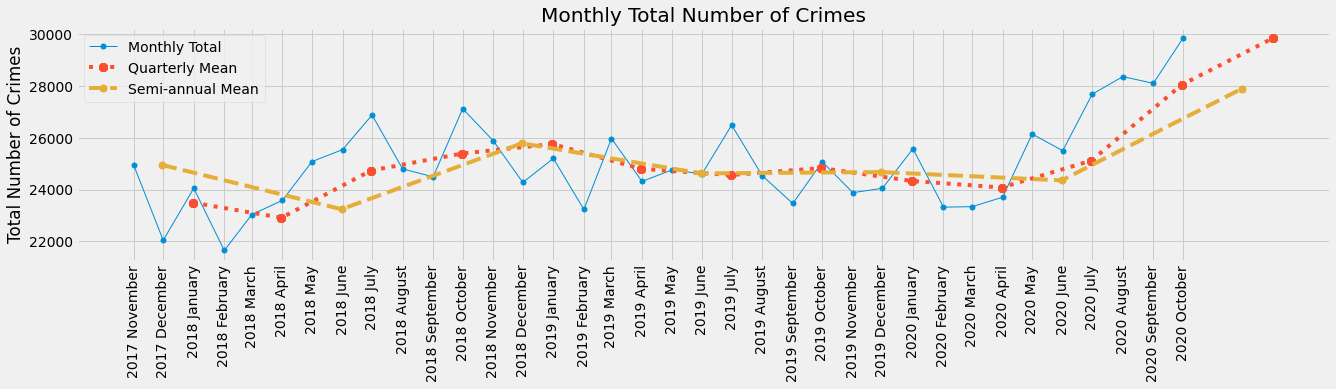

In [29]:
# plot monthly total
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize = (20, 4))

ax.plot(monthly_total.Total, 
        marker = '.', markersize = 10, linestyle = '-', linewidth = 1, label = 'Monthly Total')
ax.plot(quarterly_mean,
        marker = '8', markersize = 8, linestyle = 'dotted', label = 'Quarterly Mean')
ax.plot(semi_ann,
       marker = 'o', markersize = 7, linestyle = '--', label = 'Semi-annual Mean')


ax.set_title('Monthly Total Number of Crimes')
ax.set_ylabel('Total Number of Crimes')
ax.set_xticks(monthly_total.index)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y %B"))
plt.xticks(rotation = 90)

ax.legend()

plt.show()

### Monthly Average Temperature and Total Number of Crimes

In [24]:
mapping = dict(crime1[['Month', 'Avg_temp']].values)
monthly_total['Avg_temp'] = mapping.values()

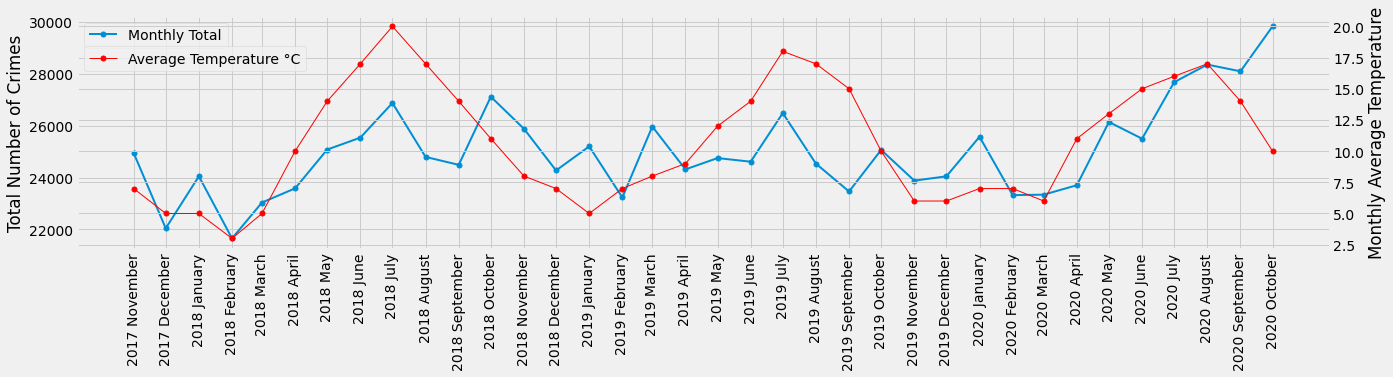

In [25]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize = (20, 4))
# make a plot
ax.plot(monthly_total.Total, marker = '.', markersize = 10, linestyle = '-', linewidth = 2,
        label = 'Monthly Total')
# set y-axis label
ax.set_ylabel('Total Number of Crimes')
# set x-axis label
ax.set_xticks(monthly_total.index)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y %B"))
plt.xticks(rotation = 90)
ax.legend()

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(monthly_total.Avg_temp, marker = '.', markersize = 10, linestyle = '-', linewidth = 1, color = 'red',
        label = 'Average Temperature °C')
ax2.set_ylabel('Monthly Average Temperature')
ax2.set_xticks(monthly_total.index)
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y %B"))
ax2.legend(loc = 'upper left', bbox_to_anchor=(0, 0.9) )

plt.show()

### Crime Hotspot

In [4]:
import geopandas as gpd
from geopandas import GeoDataFrame, GeoSeries
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely import wkt

In [5]:
# loading LSOA file
df_lsoa = pd.read_csv('wmp_areas.csv')
df_lsoa = df_lsoa.rename(columns = {"name":"LSOA"})
# converting wkt to Shapely polygon
df_lsoa['geometry'] = df_lsoa['geometry'].apply(wkt.loads)

In [6]:
# merge with crime data
geo_crime = pd.merge(crime1, df_lsoa, how ='left', on = ['LSOA'])
geo_crime.drop(['label', 'code'], axis = 1, inplace = True)
# convert to geopandas
geo_crime = gpd.GeoDataFrame(geo_crime, geometry='geometry')

In [ ]:
# plot WMP areas
fig, ax = plt.subplots(1, figsize=(20, 10))
geo_crime.plot(ax = ax, color = "whitesmoke", edgecolor = "grey", linewidth = 0.5)
ax.set_title('LSOA boundaries within West Midlands Policing Areas')
plt.show()

In [7]:
# location pivot table
loc_total = crime1.pivot_table(index = 'LSOA', values = 'Total', aggfunc='sum')
loc_total['Mean_total'] = loc_total['Total']/36 # to get monthly mean over 36 months
# add geometry
loc_total = pd.merge(loc_total, df_lsoa, how ='left', on = ['LSOA'])
loc_total.drop(['label', 'code'], axis = 1, inplace = True)
loc_total = gpd.GeoDataFrame(loc_total, geometry='geometry')

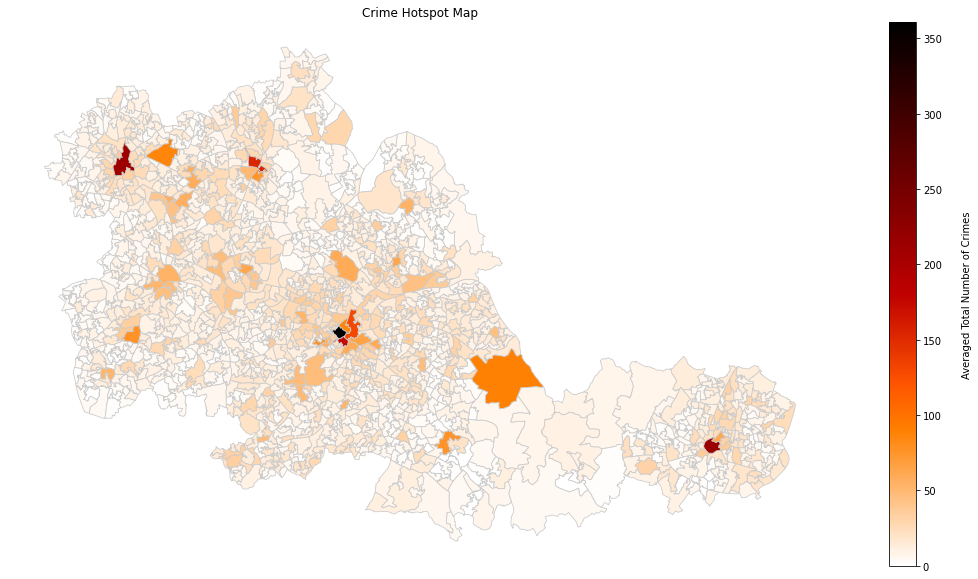

In [12]:
# set the range for the choropleth values
vmin, vmax = 0, max((loc_total['Mean_total']))

fig, ax = plt.subplots(1, figsize=(20, 10))
ax.set_title('Crime Hotspot Map')
ax.axis('off')# remove axis

# colorbar
sm = plt.cm.ScalarMappable(cmap='gist_heat_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([]) # empty array for the data range
cbar = fig.colorbar(sm)
cbar.set_label('Averaged Total Number of Crimes', labelpad = 20, rotation= 90)

loc_total.plot(column = 'Mean_total', cmap="gist_heat_r", linewidth=0.8, ax=ax, edgecolor='0.8')

plt.show()

In [13]:
loc_total[loc_total['Mean_total'] > 100]

LSOA    Total  Mean_total  \
238      Birmingham 050E   4733.0  131.472222   
609      Birmingham 135C   6325.0  175.694444   
620      Birmingham 138A  12981.0  360.583333   
775        Coventry 031C   7741.0  215.027778   
1474        Walsall 030A   5562.0  154.500000   
1616  Wolverhampton 020F   7667.0  212.972222   

                                               geometry  
238   POLYGON ((407999.815 288555.631, 408000.405 28...  
609   POLYGON ((407373.813 286599.905, 407388.812 28...  
620   POLYGON ((406971.482 287420.425, 406971.432 28...  
775   POLYGON ((433400.000 279363.333, 433388.592 27...  
1474  POLYGON ((400669.860 299465.302, 400676.437 29...  
1616  POLYGON ((391984.010 300074.380, 391987.781 30...

### Monthly Crime Hotspot 

In [14]:
# location-month pivot table
loc_month = crime1.pivot_table(index = 'LSOA', columns = 'Month', values = 'Total', aggfunc='sum')
# add geometry
loc_month = pd.merge(loc_month, df_lsoa, how ='left', on = ['LSOA'])
loc_month.drop(['label', 'code'], axis = 1, inplace = True)
loc_month = gpd.GeoDataFrame(loc_month, geometry='geometry')

In [15]:
# fix month column names
date_columns = crime1.Month.unique()
date_columns = pd.to_datetime(date_columns).strftime('%Y-%m')
date_columns = date_columns.insert(0, 'LSOA')
date_columns = date_columns.insert(37, 'geometry')
loc_month.columns = date_columns

In [284]:
def month_update(month):
    # set the value column that will be visualised
    variable = month
    # set the range for the choropleth values
    vmin, vmax = 0, max(loc_month[month])
                        
    fig, ax = plt.subplots(1, figsize=(20, 10))
    ax.set_title('Monthly Crime Hotspot Map')
    ax.axis('off')# remove axis
                        
    # colorbar
    sm = plt.cm.ScalarMappable(cmap='gist_heat_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([]) # empty array for the data range
    cbar = fig.colorbar(sm)
    cbar.set_label('Monthly Total Number of Crimes', labelpad = 20, rotation= 90)
    
    loc_month.plot(column = variable, cmap="gist_heat_r", linewidth=0.8, ax=ax, edgecolor='0.8')
    
    plt.show()

# set months 
m = list(loc_month.columns[1:-1])
interact(month_update, month = m)

interactive(children=(Dropdown(description='month', options=('2017-11', '2017-12', '2018-01', '2018-02', '2018…

<function __main__.month_update(month)>

In [16]:
loc_month_max = crime1.pivot_table(index = 'LSOA', columns = ['Month'], values = 'Total', aggfunc='sum')
max_lst = list(loc_month_max.max())
max_loc_lst = []
for month in loc_month_max.columns:
    max_loc = loc_month_max[loc_month_max[month] == loc_month_max[month].max()].index
    max_loc_lst.append(max_loc[0])  

In [17]:
loc_month_max.describe()

Month   2017-11-01   2017-12-01   2018-01-01   2018-02-01   2018-03-01  \
count  1680.000000  1680.000000  1680.000000  1680.000000  1680.000000   
mean     14.850000    13.120238    14.314881    12.887500    13.711905   
std      20.117141    18.046524    17.866430    15.979359    18.392429   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       6.000000     6.000000     7.000000     6.000000     6.000000   
50%      11.000000    10.000000    11.000000    10.000000    10.000000   
75%      17.000000    15.000000    17.000000    15.000000    16.000000   
max     460.000000   419.000000   399.000000   354.000000   418.000000   

Month   2018-04-01   2018-05-01   2018-06-01   2018-07-01   2018-08-01  ...  \
count  1680.000000  1680.000000  1680.000000  1680.000000  1680.000000  ...   
mean     14.036905    14.927381    15.201190    15.996429    14.758333  ...   
std      17.955602    17.944079    17.511912    18.463266    17.716312  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       6.000000     7.000000     7.000000     7.000000     6.000000  ...   
50%      10.000000    11.000000    12.000000    12.000000    11.000000  ...   
75%      17.000000    18.000000    18.000000    20.000000    18.000000  ...   
max     380.000000   394.000000   372.000000   398.000000   369.000000  ...   

Month   2020-01-01   2020-02-01   2020-03-01   2020-04-01   2020-05-01  \
count  1680.000000  1680.000000  1680.000000  1680.000000  1680.000000   
mean     15.220833    13.881548    13.892262    14.108929    15.560119   
std      17.807405    17.556434    15.135235    10.831512    11.217433   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       7.000000     6.000000     6.000000     6.750000     7.750000   
50%      11.500000    11.000000    11.000000    12.000000    13.000000   
75%      19.000000    17.000000    18.000000    18.000000    21.000000   
max     409.000000   390.000000   298.000000   105.000000   112.000000   

Month   2020-06-01   2020-07-01   2020-08-01   2020-09-01   2020-10-01  
count  1680.000000  1680.000000  1680.000000  1680.000000  1680.000000  
mean     15.176786    16.474405    16.877381    16.723214    17.754762  
std      12.288387    14.749949    15.790558    16.482096    17.362082  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       7.000000     7.750000     8.000000     8.000000     8.000000  
50%      13.000000    13.000000    14.000000    13.000000    14.000000  
75%      20.000000    22.000000    22.000000    21.000000    23.000000  
max     191.000000   258.000000   292.000000   321.000000   299.000000  

[8 rows x 36 columns]

In [18]:
loc_month_max.sort_values(by = list(loc_month_max.columns), ascending = False)

Month               2017-11-01  2017-12-01  2018-01-01  2018-02-01  \
LSOA                                                                 
Birmingham 138A          460.0       419.0       399.0       354.0   
Wolverhampton 020F       313.0       273.0       256.0       202.0   
Coventry 031C            245.0       207.0       209.0       168.0   
Walsall 030A             177.0       170.0       156.0       164.0   
Birmingham 135C          175.0       209.0       198.0       171.0   
...                        ...         ...         ...         ...   
Sandwell 022B              0.0         5.0         3.0         5.0   
Dudley 030A                0.0         3.0         7.0         8.0   
Walsall 032A               0.0         2.0         1.0         1.0   
Birmingham 042B            0.0         1.0         7.0         3.0   
Birmingham 003B            0.0         0.0         3.0         0.0   

Month               2018-03-01  2018-04-01  2018-05-01  2018-06-01  \
LSOA                                                                 
Birmingham 138A          418.0       380.0       394.0       372.0   
Wolverhampton 020F       220.0       237.0       217.0       226.0   
Coventry 031C            237.0       259.0       198.0       176.0   
Walsall 030A             165.0       163.0       204.0       165.0   
Birmingham 135C          229.0       214.0       177.0       189.0   
...                        ...         ...         ...         ...   
Sandwell 022B              5.0         7.0         6.0         6.0   
Dudley 030A                7.0         1.0         4.0         2.0   
Walsall 032A               3.0         2.0         2.0         1.0   
Birmingham 042B            4.0         4.0         5.0         4.0   
Birmingham 003B            2.0         0.0         4.0         3.0   

Month               2018-07-01  2018-08-01  ...  2020-01-01  2020-02-01  \
LSOA                                        ...                           
Birmingham 138A          398.0       369.0  ...       409.0       390.0   
Wolverhampton 020F       263.0       230.0  ...       195.0       187.0   
Coventry 031C            246.0       252.0  ...       250.0       241.0   
Walsall 030A             157.0       137.0  ...       146.0       135.0   
Birmingham 135C          181.0       185.0  ...       178.0       230.0   
...                        ...         ...  ...         ...         ...   
Sandwell 022B              5.0         2.0  ...         7.0         1.0   
Dudley 030A                6.0         7.0  ...         0.0         2.0   
Walsall 032A               6.0         4.0  ...         2.0         1.0   
Birmingham 042B            4.0         7.0  ...        14.0         6.0   
Birmingham 003B            5.0         0.0  ...         8.0         6.0   

Month               2020-03-01  2020-04-01  2020-05-01  2020-06-01  \
LSOA                                                                 
Birmingham 138A          298.0       105.0       112.0       191.0   
Wolverhampton 020F       182.0        82.0        87.0        92.0   
Coventry 031C            211.0        78.0        85.0       119.0   
Walsall 030A             108.0        89.0        81.0       109.0   
Birmingham 135C          122.0        45.0        45.0        57.0   
...                        ...         ...         ...         ...   
Sandwell 022B              2.0         4.0         6.0         4.0   
Dudley 030A                9.0         6.0         2.0         4.0   
Walsall 032A               1.0         5.0         3.0         2.0   
Birmingham 042B            8.0         2.0         8.0         6.0   
Birmingham 003B            4.0         3.0         2.0         6.0   

Month               2020-07-01  2020-08-01  2020-09-01  2020-10-01  
LSOA                                                                
Birmingham 138A          258.0       292.0       321.0       299.0  
Wolverhampton 020F       161.0       174.0       171.0       191.0  
Coventry 031C  

In [19]:
max_loc = pd.DataFrame()
max_loc['Month'] = loc_month_max.columns
max_loc['LSOA_max'] = max_loc_lst
max_loc['Max_total'] = max_lst
max_loc

Month         LSOA_max  Max_total
0   2017-11-01  Birmingham 138A      460.0
1   2017-12-01  Birmingham 138A      419.0
2   2018-01-01  Birmingham 138A      399.0
3   2018-02-01  Birmingham 138A      354.0
4   2018-03-01  Birmingham 138A      418.0
5   2018-04-01  Birmingham 138A      380.0
6   2018-05-01  Birmingham 138A      394.0
7   2018-06-01  Birmingham 138A      372.0
8   2018-07-01  Birmingham 138A      398.0
9   2018-08-01  Birmingham 138A      369.0
10  2018-09-01  Birmingham 138A      352.0
11  2018-10-01  Birmingham 138A      423.0
12  2018-11-01  Birmingham 138A      447.0
13  2018-12-01  Birmingham 138A      414.0
14  2019-01-01  Birmingham 138A      441.0
15  2019-02-01  Birmingham 138A      356.0
16  2019-03-01  Birmingham 138A      403.0
17  2019-04-01  Birmingham 138A      299.0
18  2019-05-01  Birmingham 138A      336.0
19  2019-06-01  Birmingham 138A      354.0
20  2019-07-01  Birmingham 138A      445.0
21  2019-08-01  Birmingham 138A      404.0
22  2019-09-01  Birmingham 138A      396.0
23  2019-10-01  Birmingham 138A      385.0
24  2019-11-01  Birmingham 138A      429.0
25  2019-12-01  Birmingham 138A      459.0
26  2020-01-01  Birmingham 138A      409.0
27  2020-02-01  Birmingham 138A      390.0
28  2020-03-01  Birmingham 138A      298.0
29  2020-04-01  Birmingham 138A      105.0
30  2020-05-01  Birmingham 138A      112.0
31  2020-06-01  Birmingham 138A      191.0
32  2020-07-01  Birmingham 138A      258.0
33  2020-08-01  Birmingham 138A      292.0
34  2020-09-01  Birmingham 138A      321.0
35  2020-10-01  Birmingham 138A      299.0

### Median House Price by LSOA

In [20]:
# location-price pivot table
loc_price = crime1.pivot_table(index = 'LSOA', values = 'Med_price', aggfunc='sum')
loc_price['Avg_median_price'] = loc_price['Med_price']/36 # to get monthly mean over 36 months
# add geometry
loc_price = pd.merge(loc_price, df_lsoa, how ='left', on = ['LSOA'])
loc_price.drop(['label', 'code'], axis = 1, inplace = True)
loc_price = gpd.GeoDataFrame(loc_price, geometry='geometry')

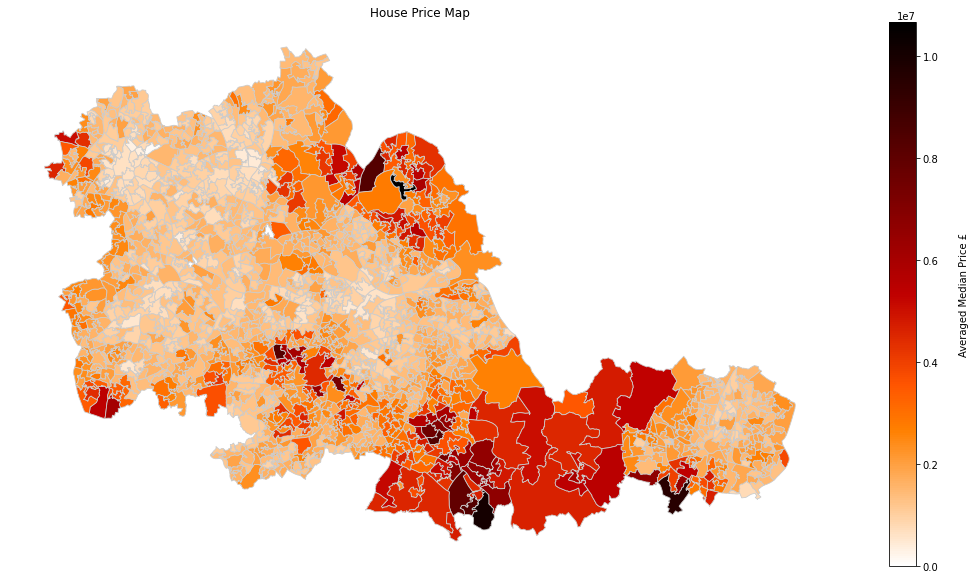

In [21]:
# set the range for the choropleth values
vmin, vmax = 0, max((loc_price['Avg_median_price']))

fig, ax = plt.subplots(1, figsize=(20, 10))
ax.set_title('House Price Map')
ax.axis('off')# remove axis

# colorbar
sm = plt.cm.ScalarMappable(cmap='gist_heat_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([]) # empty array for the data range
cbar = fig.colorbar(sm)
cbar.set_label('Averaged Median Price £', labelpad = 20, rotation= 90)

loc_price.plot(column = 'Avg_median_price', cmap="gist_heat_r", linewidth=0.8, ax=ax, edgecolor='0.8')

plt.show()

### Universal Credit Map

In [22]:
# location-uni_credit pivot table
loc_uc = crime1.pivot_table(index = 'LSOA', values = 'Uni_credit', aggfunc='sum')
loc_uc['Avg_uc'] = loc_uc['Uni_credit']/36 # to get monthly mean over 36 months
# add geometry
loc_uc = pd.merge(loc_uc, df_lsoa, how ='left', on = ['LSOA'])
loc_uc.drop(['label', 'code'], axis = 1, inplace = True)
loc_uc = gpd.GeoDataFrame(loc_uc, geometry='geometry')

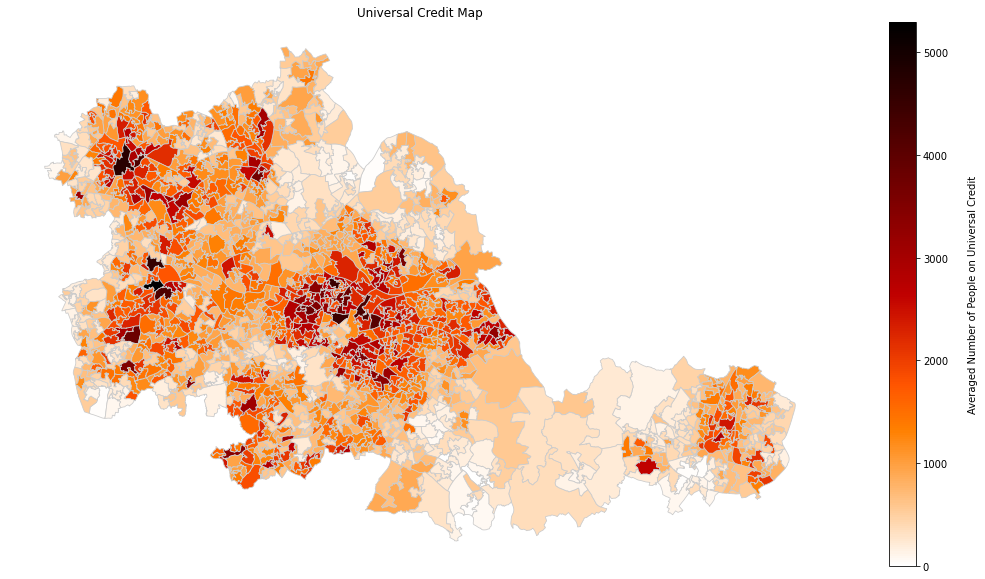

In [23]:
# set the range for the choropleth values
vmin, vmax = 0, max((loc_uc['Avg_uc']))

fig, ax = plt.subplots(1, figsize=(20, 10))
ax.set_title('Universal Credit Map')
ax.axis('off')# remove axis

# colorbar
sm = plt.cm.ScalarMappable(cmap='gist_heat_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([]) # empty array for the data range
cbar = fig.colorbar(sm)
cbar.set_label('Averaged Number of People on Universal Credit', labelpad = 20, rotation= 90)

loc_uc.plot(column = 'Avg_uc', cmap="gist_heat_r", linewidth=0.8, ax=ax, edgecolor='0.8')

plt.show()

#### Comparison of maps

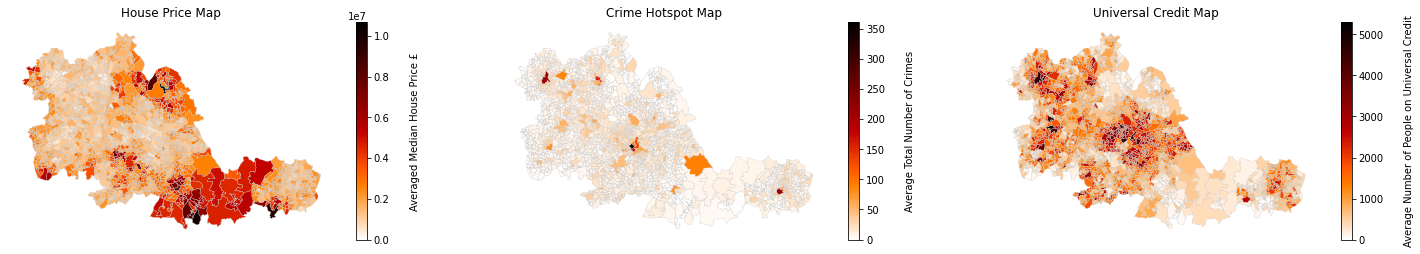

In [24]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(25, 10))

vmin1, vmax1 = 0, max((loc_price['Avg_median_price']))
vmin2, vmax2 = 0, max((loc_total['Mean_total']))
vmin3, vmax3 = 0, max((loc_uc['Avg_uc']))

ax[0].set_title('House Price Map')
ax[0].axis('off')

ax[1].set_title('Crime Hotspot Map')
ax[1].axis('off')

ax[2].set_title('Universal Credit Map')
ax[2].axis('off')

sm1 = plt.cm.ScalarMappable(cmap='gist_heat_r', norm=plt.Normalize(vmin=vmin1, vmax=vmax1))
sm2 = plt.cm.ScalarMappable(cmap='gist_heat_r', norm=plt.Normalize(vmin=vmin2, vmax=vmax2))
sm3 = plt.cm.ScalarMappable(cmap='gist_heat_r', norm=plt.Normalize(vmin=vmin3, vmax=vmax3))

sm1.set_array([]) 
sm2.set_array([])
sm3.set_array([])


cbar1 = fig.colorbar(sm1, ax = ax[0], shrink = 0.4)
cbar1.set_label('Averaged Median House Price £', labelpad = 20, rotation= 90 ) 
cbar2 = fig.colorbar(sm2, ax = ax[1], shrink = 0.4)
cbar2.set_label('Average Total Number of Crimes', labelpad = 20, rotation= 90)
cbar3 = fig.colorbar(sm3, ax = ax[2], shrink = 0.4)
cbar3.set_label('Average Number of People on Universal Credit', labelpad = 20, rotation= 90)

loc_price.plot(column = 'Avg_median_price', cmap='gist_heat_r', linewidth=0.3, ax=ax[0], edgecolor='0.8')
loc_total.plot(column = 'Mean_total', cmap='gist_heat_r', linewidth=0.3, ax=ax[1], edgecolor='0.8')
loc_uc.plot(column = 'Avg_uc', cmap="gist_heat_r", linewidth=0.3, ax=ax[2], edgecolor='0.8')

plt.show()

### Correlation Matrix

<AxesSubplot:>

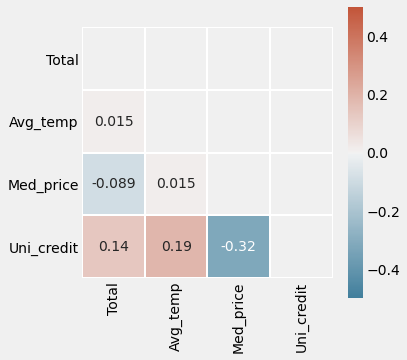

In [43]:
# correlation matrix
corr = crime1.corr()

# mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(5, 5))

# generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.5, vmin = -0.5, center=0, square=True, linewidths=1, annot = True)

### Crime Breakdown by Type

In [25]:
# pivot table for type 
type_total = crime1.pivot_table(index = 'Type', values = 'Total', aggfunc = 'sum')
type_total = type_total.sort_values('Total')

In [26]:
type_total

Total
Type                                  
Bicycle theft                   7704.0
Possession of weapons           8145.0
Theft from the person           8630.0
Other crime                    12851.0
Drugs                          15358.0
Robbery                        23876.0
Shoplifting                    47807.0
Public order                   51886.0
Other theft                    62941.0
Criminal damage and arson      72365.0
Burglary                       76194.0
Vehicle crime                  97555.0
Anti-social behaviour         134346.0
Violence and sexual offences  280756.0

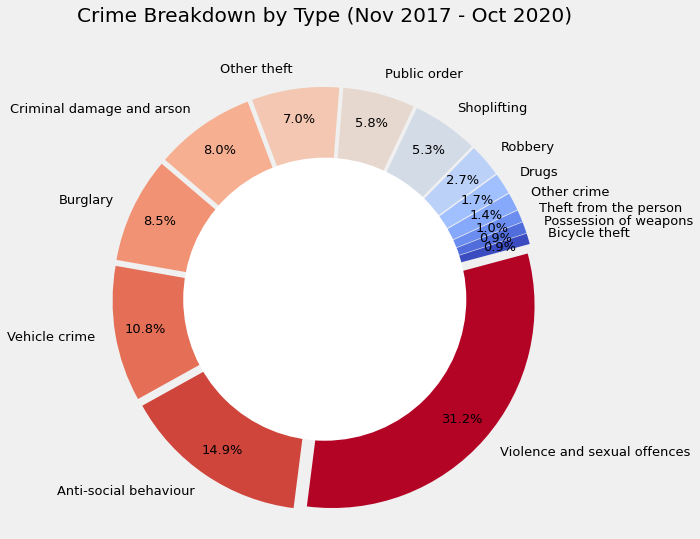

In [30]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))

cmap = plt.cm.coolwarm
colors = cmap(np.linspace(0., 1., 14))

explode = [0.05]*14

# pie chart
wedges = ax.pie(type_total['Total'], labels = type_total.index, startangle = 15,
                colors = colors, autopct="%.1f%%", explode = explode, textprops={'fontsize': 13},
               pctdistance=0.85)
#draw circle
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')  

ax.set_title("Crime Breakdown by Type (Nov 2017 - Oct 2020)", y = 1.08)

plt.show()

### Monthly Total Number of Crimes for Different Types

In [31]:
# pivot table monthly type
monthly_type = crime1.pivot_table(index = 'Month', columns = 'Type', values = 'Total', aggfunc='sum')

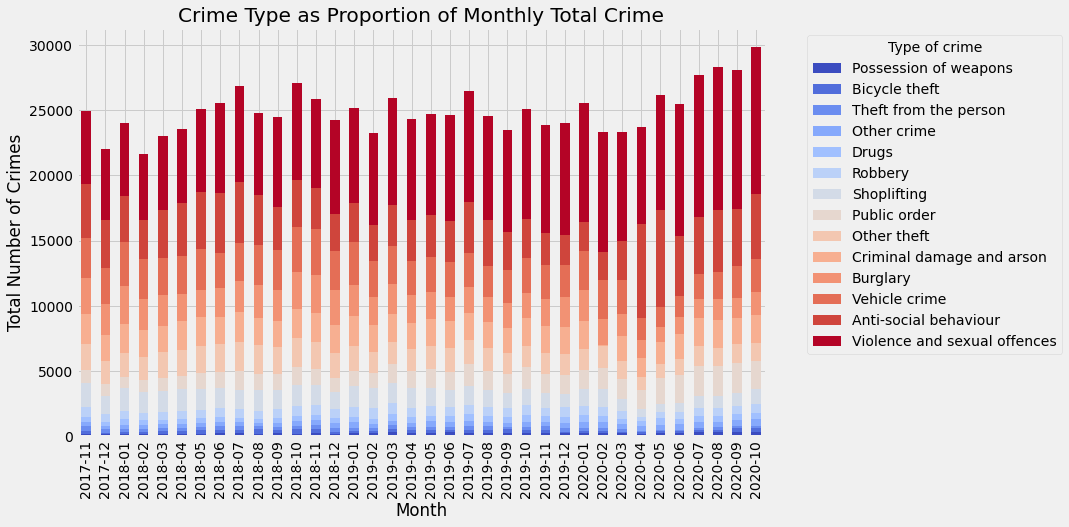

In [32]:
# plot monthly type
plot_monthly_type = monthly_type.loc[:, ['Possession of weapons', 'Bicycle theft', 'Theft from the person', 
                                         'Other crime', 'Drugs', 'Robbery', 'Shoplifting', 'Public order',
                                         'Other theft', 'Criminal damage and arson', 'Burglary', 'Vehicle crime',
                                         'Anti-social behaviour', 'Violence and sexual offences']]
plot_monthly_type.index = pd.to_datetime(plot_monthly_type.index)
plot_monthly_type.index = plot_monthly_type.index.strftime("%Y-%m") 

ax = plot_monthly_type.plot(kind = 'bar', stacked = True, cmap = 'coolwarm', figsize = (11, 7))
ax.set_title('Crime Type as Proportion of Monthly Total Crime')
ax.set_ylabel('Total Number of Crimes')

plt.legend(title = 'Type of crime', bbox_to_anchor=(1.05, 1), loc = 'upper left')

plt.show()

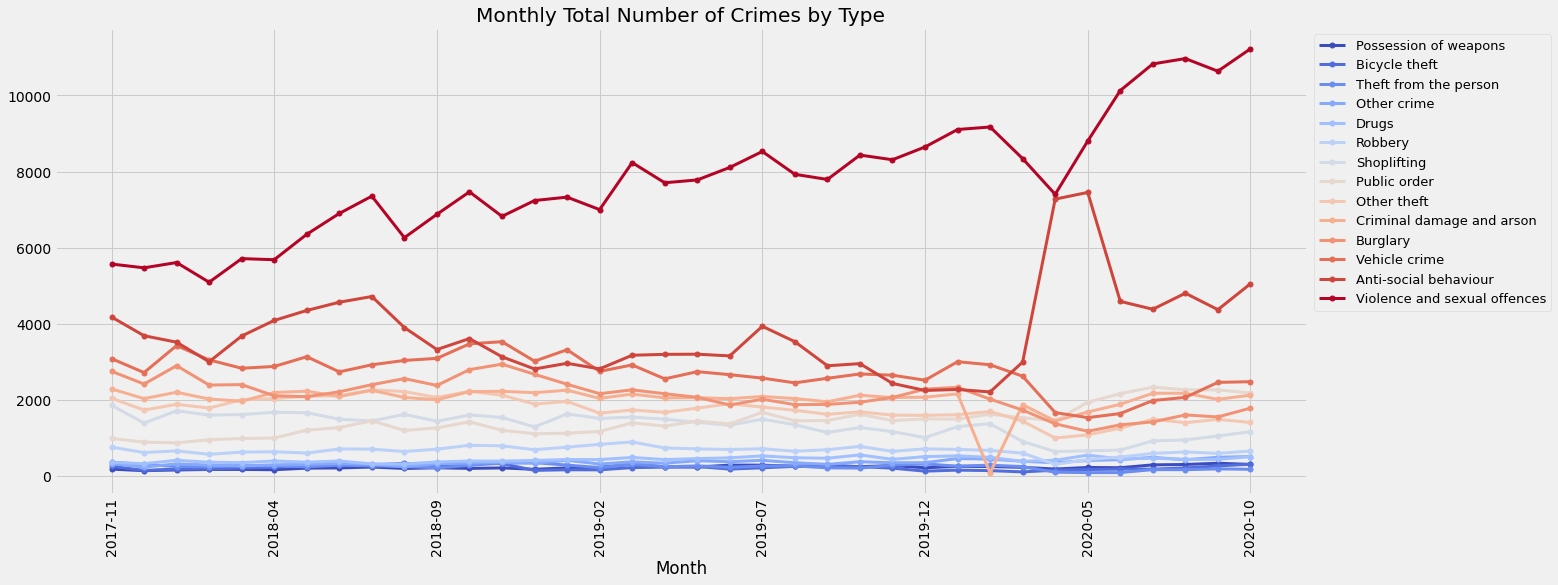

In [220]:
# plot monthly total number of crimes by type
ax = plot_monthly_type.plot(x_compat = True, marker = '.', markersize = 10, linestyle = '-', linewidth = 3,
                            title = 'Monthly Total Number of Crimes by Type', colormap = 'coolwarm',
                            figsize = (20, 8))

plt.xticks(rotation = 90)
                             
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), fontsize = 13)
plt.show()

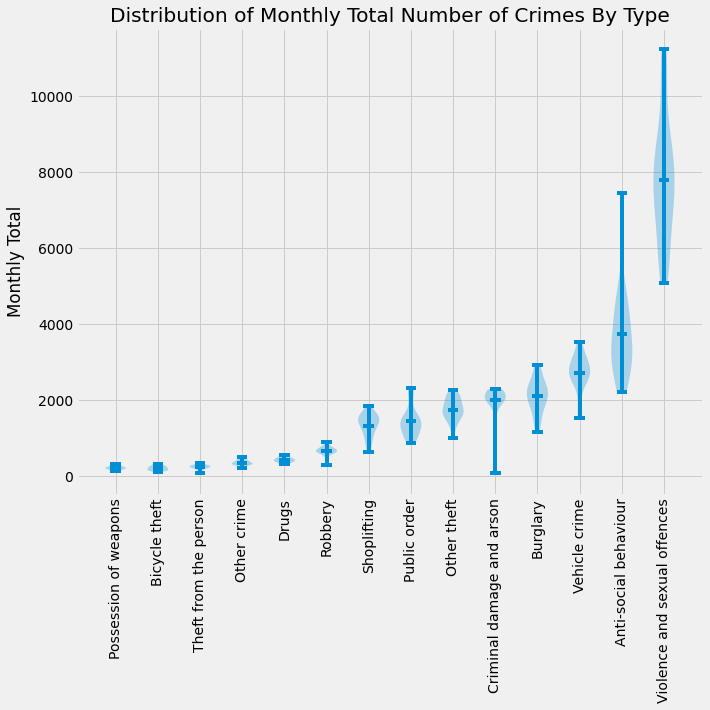

In [49]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch

# violine plot
fig, ax = plt.subplots(figsize = (10, 8))

labels = list(plot_monthly_type.columns)

violins = ax.violinplot(plot_monthly_type, widths=0.5, showmeans=True, showextrema=True)

for violin in violins['bodies']:
    path = Path(violin.get_paths()[0].vertices)
    patch = PathPatch(path, facecolor= 'none', edgecolor='none')
    ax.add_patch(patch)

ax.set_title('Distribution of Monthly Total Number of Crimes By Type')
ax.set_ylabel('Monthly Total')

ax.set_xticks(list(np.arange(1, 15, 1)))
ax.set_xticklabels(labels)
plt.xticks(rotation = 90)
plt.show()

### Crime Hotspot by Type

In [36]:
#loc-type pivot table
type_loc = crime1.pivot_table(index = 'LSOA', columns = 'Type', values = 'Total', aggfunc='mean')

# add geometry
type_loc = pd.merge(type_loc, df_lsoa, how ='left', on = 'LSOA')
type_loc.drop(['label', 'code'], axis = 1, inplace = True)
type_loc = gpd.GeoDataFrame(type_loc, geometry='geometry')

In [37]:
type_loc.describe()

Anti-social behaviour  Bicycle theft     Burglary  \
count            1680.000000    1680.000000  1680.000000   
mean                2.221329       0.127381     1.259821   
std                 2.550519       0.484989     0.813144   
min                 0.083333       0.000000     0.083333   
25%                 0.972222       0.027778     0.750000   
50%                 1.750000       0.055556     1.083333   
75%                 2.694444       0.111111     1.555556   
max                61.500000      12.638889    10.666667   

       Criminal damage and arson        Drugs  Other crime  Other theft  \
count                1680.000000  1680.000000  1680.000000  1680.000000   
mean                    1.196511     0.253935     0.212483     1.040691   
std                     0.972039     0.489092     0.258888     2.017627   
min                     0.027778     0.000000     0.000000     0.000000   
25%                     0.583333     0.083333     0.083333     0.305556   
50%                     1.000000     0.166667     0.166667     0.527778   
75%                     1.555556     0.305556     0.277778     0.972222   
max                    12.722222    11.527778     8.055556    33.722222   

       Possession of weapons  Public order      Robbery  Shoplifting  \
count            1680.000000   1680.000000  1680.000000  1680.000000   
mean                0.134673      0.857903     0.394775     0.790460   
std                 0.250844      1.157659     0.731320     2.950001   
min                 0.000000      0.000000     0.000000     0.000000   
25%                 0.027778      0.361111     0.111111     0.000000   
50%                 0.083333      0.638889     0.222222     0.055556   
75%                 0.166667      1.055556     0.444444     0.388889   
max                 5.250000     26.472222    16.055556    74.166667   

       Theft from the person  Vehicle crime  Violence and sexual offences  
count            1680.000000    1680.000000                   1680.000000  
mean                0.142692       1.613013                      4.642130  
std                 0.819376       1.300368                      4.162925  
min                 0.000000       0.277778                      0.222222  
25%                 0.000000       0.944444                      2.250000  
50%                 0.027778       1.305556                      3.888889  
75%                 0.083333       1.833333                      5.944444  
max                23.472222      19.638889                     70.944444

In [38]:
max_total_lst = list(type_loc.max())[1:]

In [39]:
type_loc_max = crime1.pivot_table(index = 'LSOA', columns = 'Type', values = 'Total', aggfunc='mean')

max_type_lst = list(type_loc_max.max())
max_type_lst = []
for t in type_loc_max.columns:
    max_type = type_loc_max[type_loc_max[t] == type_loc_max[t].max()].index
    max_type_lst.append(max_type[0])

In [40]:
max_type_loc = pd.DataFrame(index = type_loc_max.columns)
max_type_loc['Hotspot'] = max_type_lst
max_type_loc['Max_avg_total'] = max_total_lst
max_type_loc

Hotspot  Max_avg_total
Type                                                           
Anti-social behaviour            Birmingham 138A      61.500000
Bicycle theft                      Coventry 031C      12.638889
Burglary                           Coventry 031C      10.666667
Criminal damage and arson     Wolverhampton 020F      12.722222
Drugs                            Birmingham 138A      11.527778
Other crime                      Birmingham 053D       8.055556
Other theft                      Birmingham 138A      33.722222
Possession of weapons              Solihull 009A       5.250000
Public order                     Birmingham 138A      26.472222
Robbery                          Birmingham 138A      16.055556
Shoplifting                      Birmingham 138A      74.166667
Theft from the person            Birmingham 138A      23.472222
Vehicle crime                      Solihull 009A      19.638889
Violence and sexual offences     Birmingham 138A      70.944444

In [45]:
import dataframe_image as dfi

dfi.export(max_type_loc, 'max_type_loc.png', table_conversion = 'matplotlib')

In [103]:
def plot_multi_map(data, column, title_name, ax_num = 0):

    vmin, vmax = 0, max(data[column])
    
    ax[ax_num].set_title(title_name)
    ax[ax_num].axis('off')

    sm = plt.cm.ScalarMappable(cmap='bone_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([]) 
    
    cbar = fig.colorbar(sm, ax = ax[ax_num], shrink = 0.4)
    cbar.set_label('Averaged Total Number of Crimes', labelpad = 20, rotation= 90 ) 
    
    data.plot(column = column, cmap='bone_r', linewidth=0.3, ax=ax[ax_num], edgecolor='0.8')  

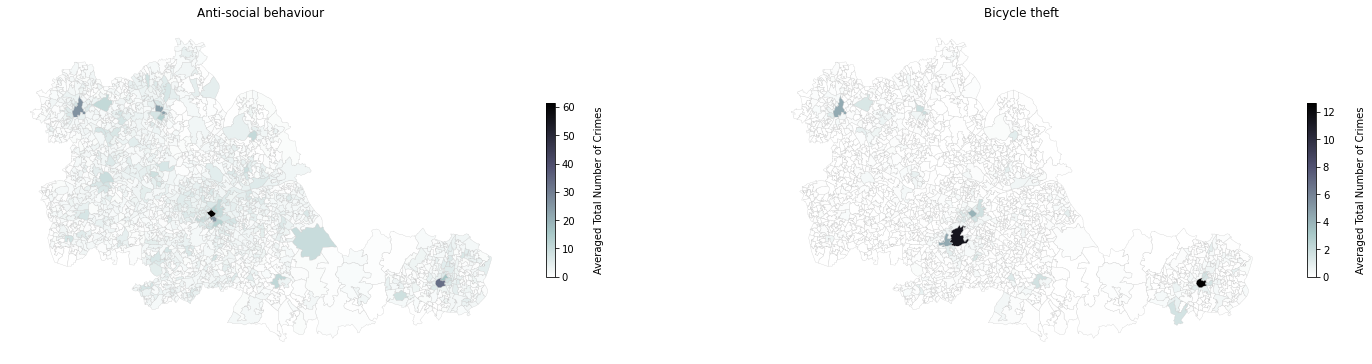

In [89]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(25, 8))
plot_multi_map(type_loc, type_loc.columns[1], type_loc.columns[1], ax_num = 0)
plot_multi_map(type_loc, type_loc.columns[2], type_loc.columns[2], ax_num = 1)

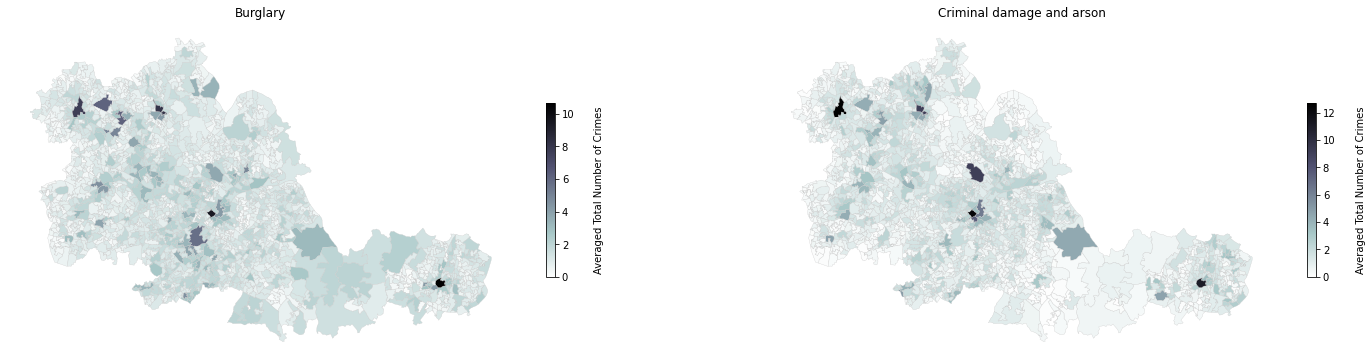

In [90]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(25, 8))
plot_multi_map(type_loc, type_loc.columns[3], type_loc.columns[3], ax_num = 0)
plot_multi_map(type_loc, type_loc.columns[4], type_loc.columns[4], ax_num = 1)

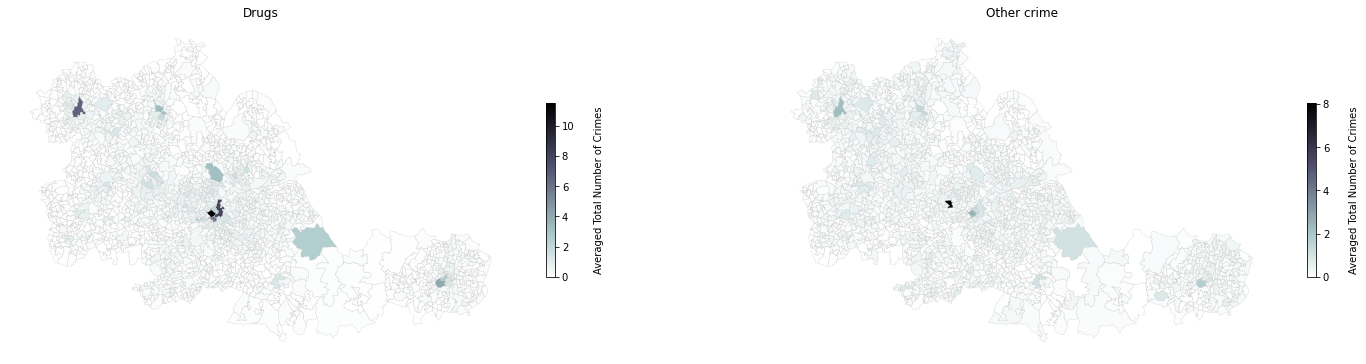

In [91]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(25, 8))
plot_multi_map(type_loc, type_loc.columns[5], type_loc.columns[5], ax_num = 0)
plot_multi_map(type_loc, type_loc.columns[6], type_loc.columns[6], ax_num = 1)

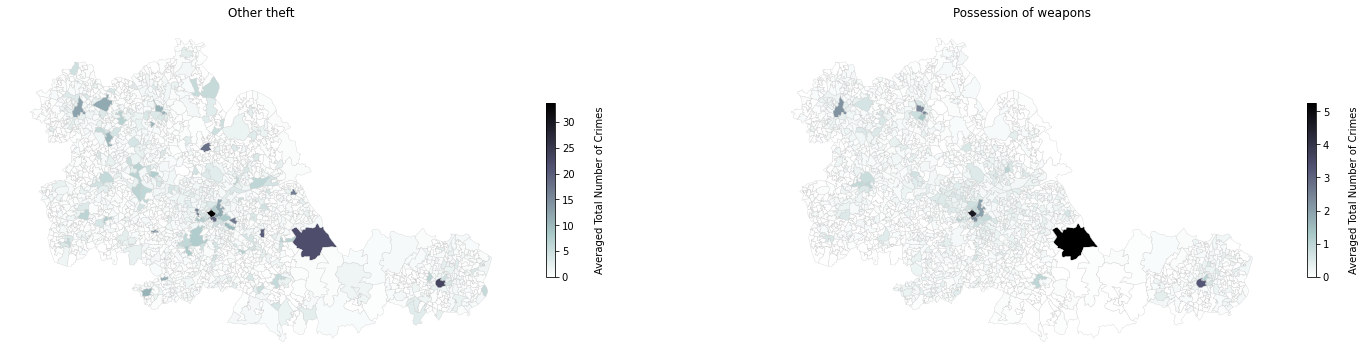

In [92]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(25, 8))
plot_multi_map(type_loc, type_loc.columns[7], type_loc.columns[7], ax_num = 0)
plot_multi_map(type_loc, type_loc.columns[8], type_loc.columns[8], ax_num = 1)

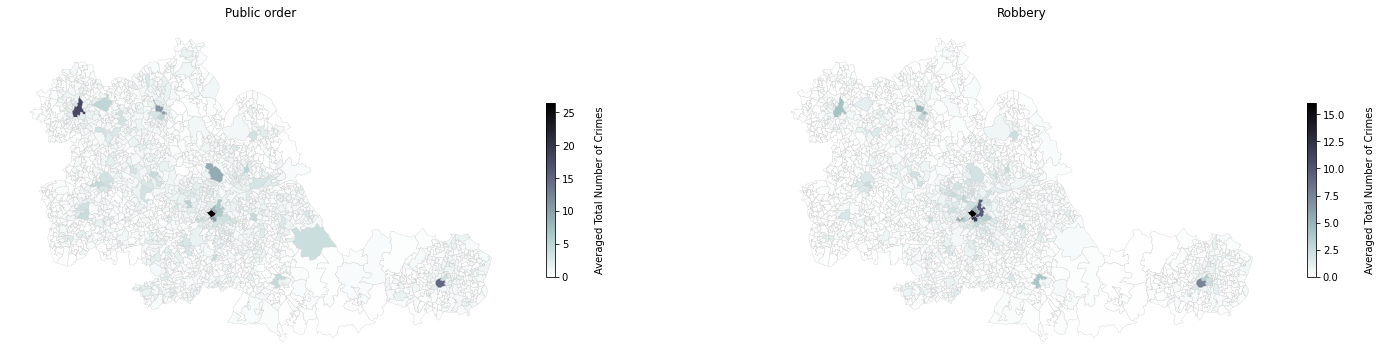

In [93]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(25, 8))
plot_multi_map(type_loc, type_loc.columns[9], type_loc.columns[9], ax_num = 0)
plot_multi_map(type_loc, type_loc.columns[10], type_loc.columns[10], ax_num = 1)

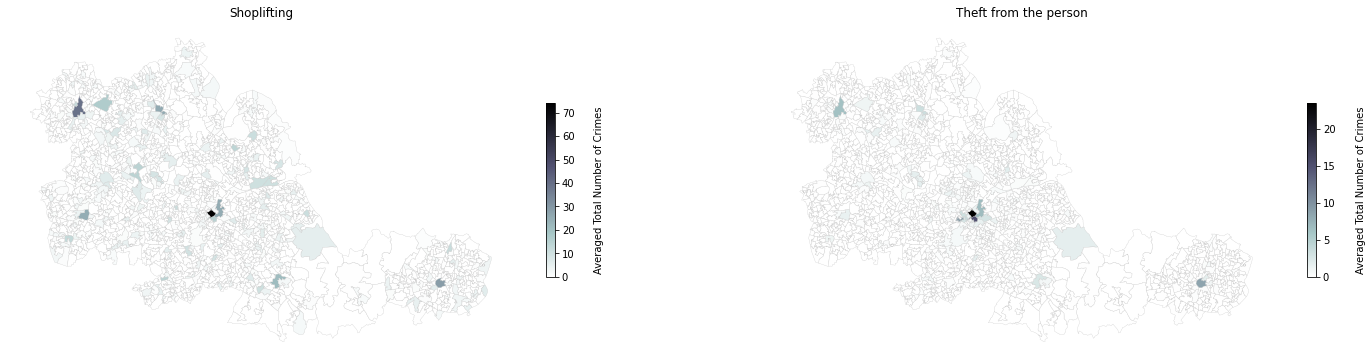

In [94]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(25, 8))
plot_multi_map(type_loc, type_loc.columns[11], type_loc.columns[11], ax_num = 0)
plot_multi_map(type_loc, type_loc.columns[12], type_loc.columns[12], ax_num = 1)

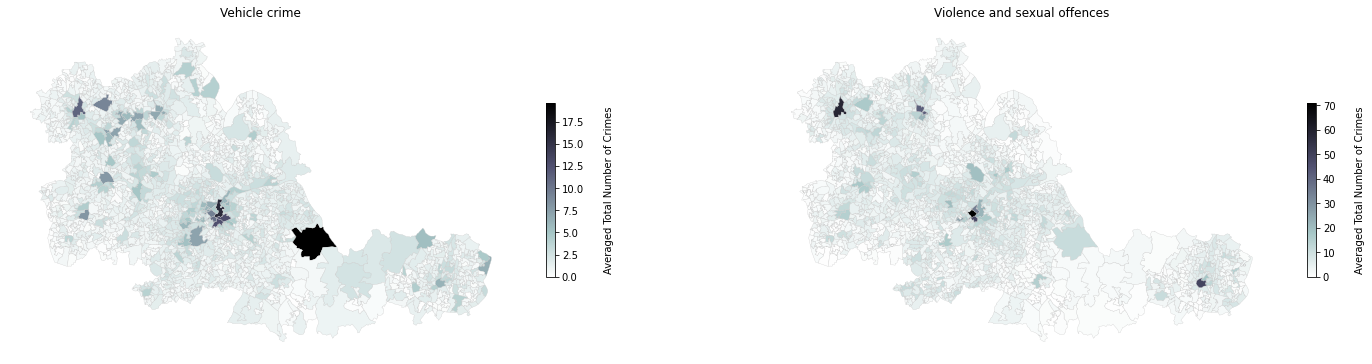

In [95]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(25, 8))
plot_multi_map(type_loc, type_loc.columns[13], type_loc.columns[13], ax_num = 0)
plot_multi_map(type_loc, type_loc.columns[14], type_loc.columns[14], ax_num = 1)